In [ ]:
'''
Deep Learning Stock Price Predictor 
Author: Gil Akos
Objective: Create Deep Learning Model with Keras LSTM
Reference: http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

TEST LOOKBACK VALUES FOR SINGLE LSTM USING ADJUSTED CLOSE AS INPUT
'''

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import required libraries for Machine Learning
import math
import numpy as np
# Fix random seed for reproducibility
np.random.seed(7)
import pandas as pd

# Import Keras Libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.metrics import mean_squared_error

# Import required libraries for Yahoo Finance API
import yahoo_finance as yf
from yahoo_finance import Share

# Import required libraries for visualization and printing
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (18, 12)
import matplotlib.dates as mdates

# Import utility libraries
import utilities as util
import datetime
import time

Using TensorFlow backend.


In [2]:
# Set Benchmark Dates based on Machine Learning for Trading course 1/1/09-6/18/15
date_start, date_end = '1995-01-01', '2015-06-18'#'2015-06-18'

# Set Additional Tickers
tick_0 = 'SPY'
tick_1 = 'GE'
tick_2 = 'MSFT'
tick_3 = 'AAPL'

# Set Baseline Model Ticker
base_ticker = tick_0

In [3]:
#Request Stock Data
stock_data = Share(base_ticker)
stock_historical = stock_data.get_historical(date_start,date_end)

#pprint(stock_historical)

#Define columns of data to keep from historical stock data
stock_item = []
stock_date = []
stock_close = []
stock_volume = []

#Loop through the stock data objects backwards and store factors we want to keep
i_counter = 0
for i in xrange(len(stock_historical)-1,-1,-1):
    d = stock_historical[i]
    stock_item.append(i_counter)
    stock_date.append(d['Date'])
    stock_close.append(d['Adj_Close'])
    stock_volume.append(d['Volume'])
    i_counter += 1

#Create a dataframe for stock data
stock_df = pd.DataFrame()
    
#Add factors to dataframe
stock_df['Item'] = stock_item
stock_df['Date'] = stock_date
stock_df['Adj_Close'] = pd.to_numeric(stock_close)
stock_df['Volume'] = pd.to_numeric(stock_volume)

#Print the dataframe head and tail
print(stock_df.head())
print("---")
print(stock_df.tail())

   Item        Date  Adj_Close  Volume
0     0  1995-01-03  30.707108  324300
1     1  1995-01-04  30.853865  351800
2     2  1995-01-05  30.853865   89800
3     3  1995-01-06  30.885254  448400
4     4  1995-01-09  30.916713   36800
---
      Item        Date   Adj_Close     Volume
5147  5147  2015-06-12  202.337412  135382400
5148  5148  2015-06-15  201.470299  124384200
5149  5149  2015-06-16  202.568649   85308200
5150  5150  2015-06-17  202.896224  126708600
5151  5151  2015-06-18  205.006216  165867900


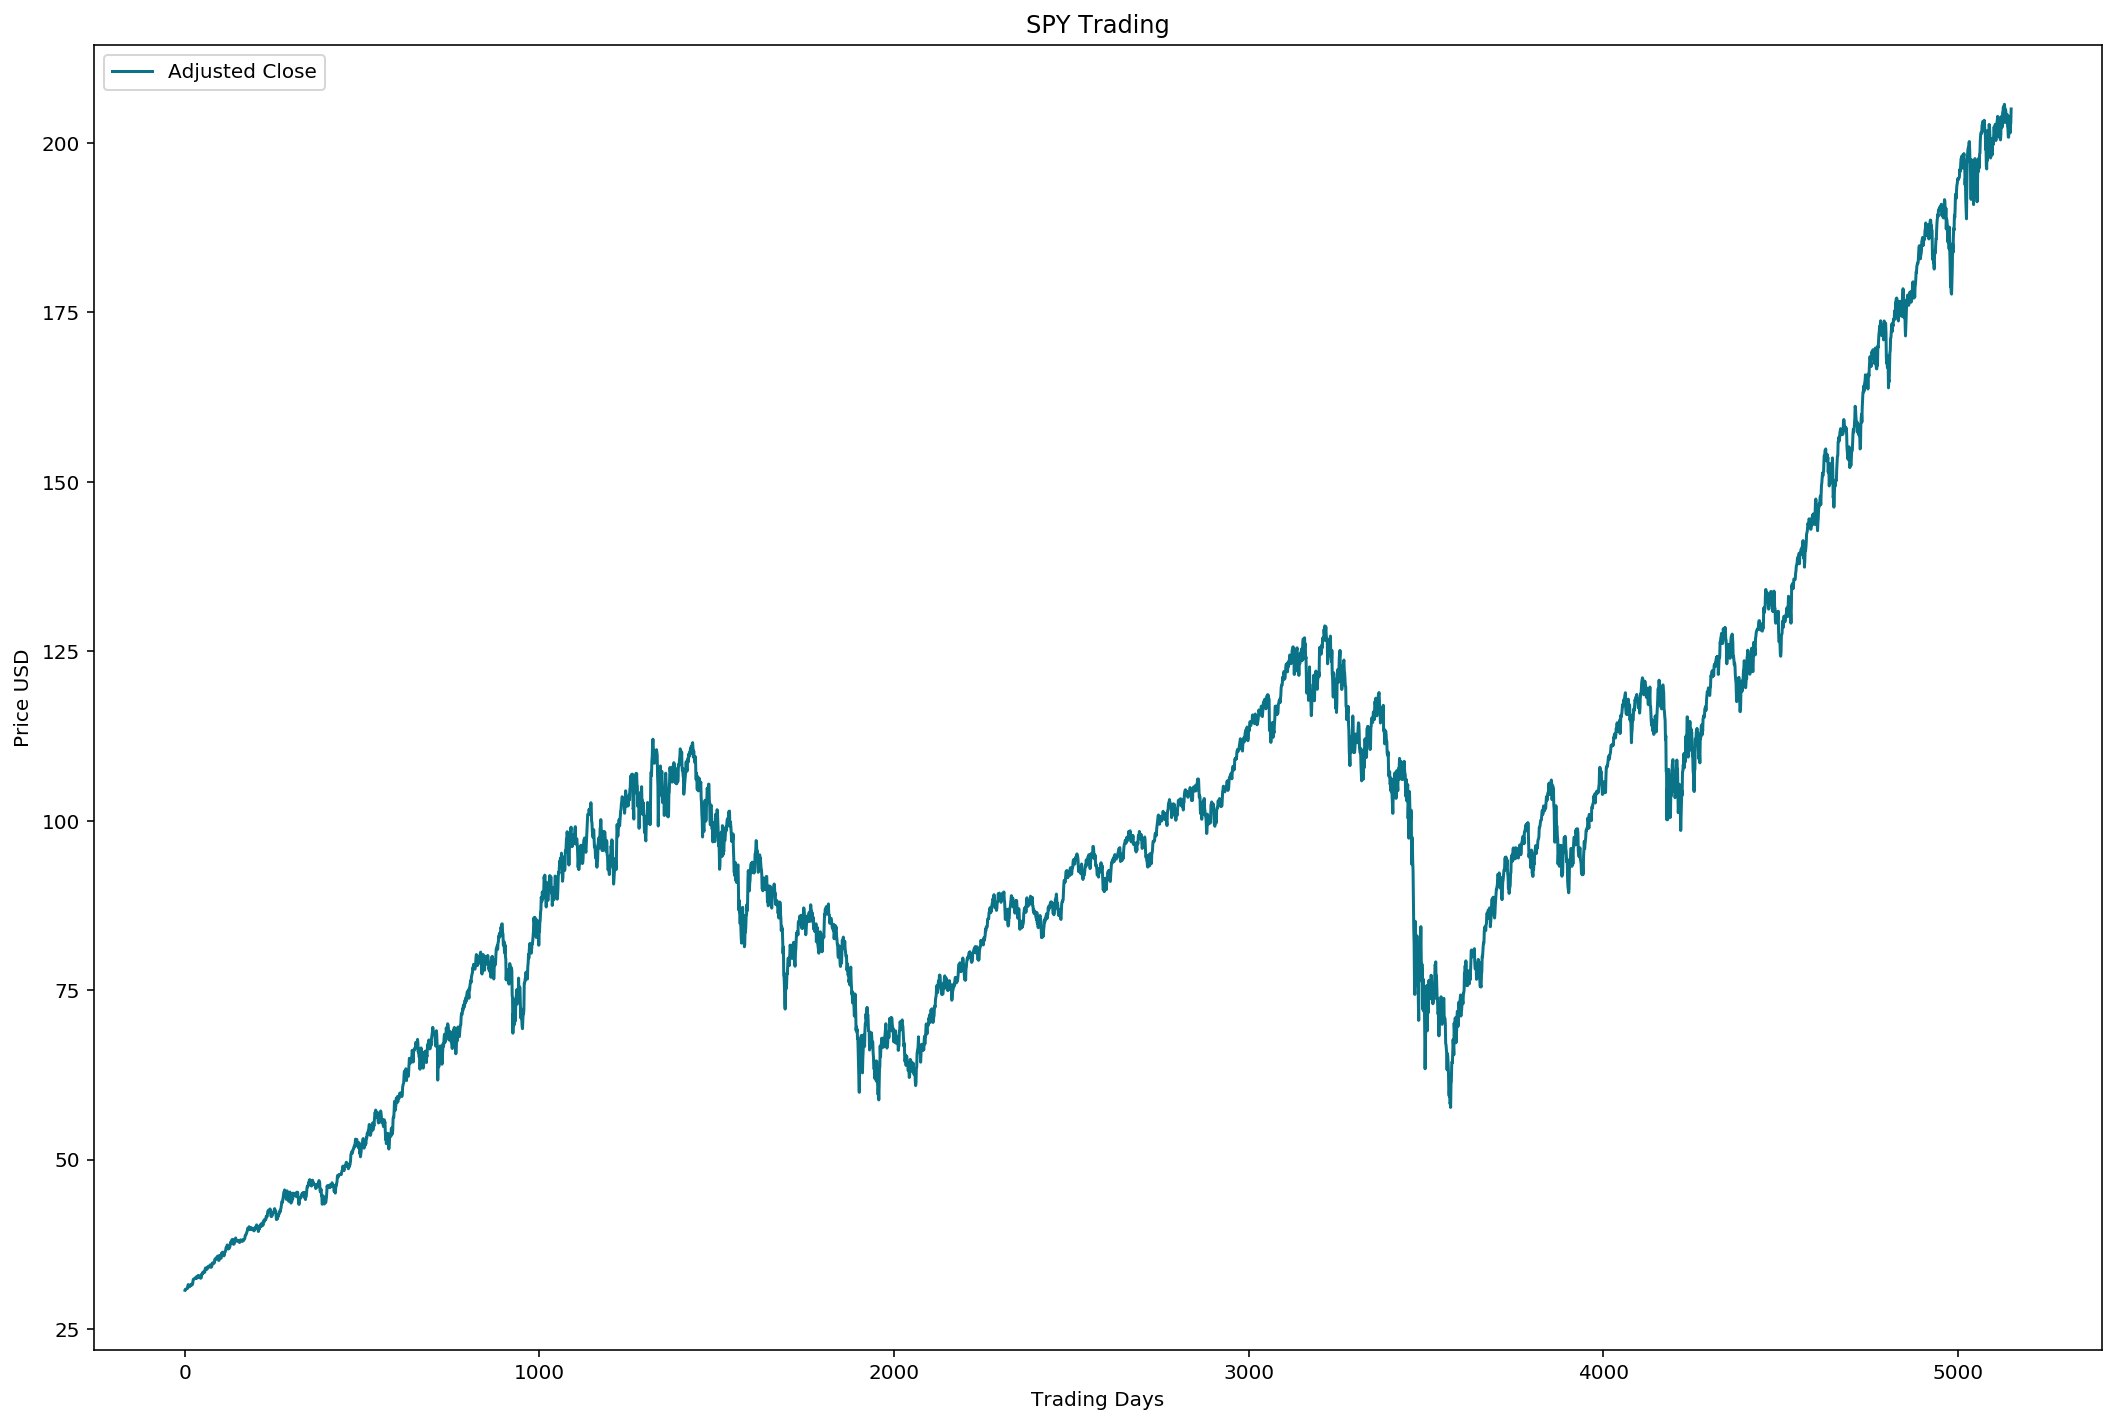

In [4]:
#Plot Basic Data
fig, ax = plt.subplots()
ax.plot(stock_df['Item'], stock_df['Adj_Close'], '#0A7388', label='Adjusted Close')

# format the coords message box
def price(x):
    return '$%1.2f' % x
#ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = price

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Add title and legend
ax.set_title(base_ticker + ' Trading')
ax.legend(loc='upper left')

plt.show()

In [5]:
#Create numpy arrays for features and targets
X_day_all = []
close_all = []

#Convert dataframe columns to numpy arrays for scikit learn
for index, row in stock_df.iterrows():
    #print([np.array(row['Item'])])
    X_day_all.append([(row['Item'])])
    close_all.append([(row['Adj_Close'])])

#pprint(X_day_all)
pprint(close_all)

[[30.707108],
 [30.853865000000003],
 [30.853865000000003],
 [30.885253999999996],
 [30.916713],
 [30.948169],
 [30.969096999999998],
 [30.979628],
 [31.346386],
 [31.535063],
 [31.545528000000004],
 [31.51407],
 [31.335922999999998],
 [31.220623],
 [31.314996],
 [31.356917],
 [31.440759000000003],
 [31.472148999999998],
 [31.597912],
 [31.461686],
 [31.587449],
 [31.576984000000003],
 [31.765596000000002],
 [32.216265],
 [32.35249],
 [32.394411],
 [32.394411],
 [32.394411],
 [32.436332],
 [32.446863],
 [32.488784],
 [32.666931],
 [32.625009999999996],
 [32.499247],
 [32.488784],
 [32.729779],
 [32.782231],
 [32.866073],
 [32.604015999999994],
 [32.876536],
 [32.666931],
 [32.708852],
 [32.719317],
 [32.74031],
 [32.488784],
 [32.572626],
 [32.562095],
 [33.04422],
 [33.012764000000004],
 [33.253825],
 [33.190909999999995],
 [33.390053],
 [33.423297],
 [33.423297],
 [33.339001],
 [33.370561],
 [33.391668],
 [33.865817],
 [34.00278],
 [34.00278],
 [33.992261],
 [33.929072],
 [33.79204],

In [6]:
# Reshape into t and t+1
look_back = 1 #50
tt_split = (1.0-.315)
#X_day_train_t, X_day_train_t1, X_day_test_t, X_day_test_t1 = create_dataset(X_day_all, look_back, tt_split, True)
#X_vol_train_t, X_vol_train_t1 = create_dataset(X_vol_train, look_back, True)
X_close_train, y_close_train, X_close_test, y_close_test, close_bounds = \
    util.create_dataset(close_all, look_back, tt_split, True)

pprint(X_close_train)
print('--')
pprint(y_close_train)

array([[[ 0.        ]],

       [[ 0.00083865]],

       [[ 0.00083865]],

       ..., 
       [[ 0.26131068]],

       [[ 0.27447625]],

       [[ 0.27394382]]])
--
array([[ 0.00083865],
       [ 0.00083865],
       [ 0.00101802],
       ..., 
       [ 0.27447625],
       [ 0.27394382],
       [ 0.27694481]])


In [7]:
# Create Keras Model
# http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

# Create and fit the LSTM network
batch_size = 1
epochs = 1 # 200
model = Sequential()
model.add(LSTM(8, batch_input_shape=(batch_size, look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_close_train, 
          y_close_train, 
          nb_epoch=epochs, 
          batch_size=batch_size, 
          verbose=2, 
          shuffle=False)


Epoch 1/1
10s - loss: 7.9745e-05


In [8]:
# Generate predictions for training
#testPredict = model.predict(X_close_test, batch_size=batch_size)
testPredict = util.predict_sequences(model, X_close_test)
pprint(testPredict)

[[0.26384947],
 [0.25900766],
 [0.25964835],
 [0.25626919],
 [0.25255328],
 [0.25283137],
 [0.24806353],
 [0.24811582],
 [0.24926528],
 [0.24143295],
 [0.24750596],
 [0.24523927],
 [0.24586722],
 [0.24686107],
 [0.24834228],
 [0.25331792],
 [0.24837711],
 [0.24537884],
 [0.24494268],
 [0.24696566],
 [0.24625085],
 [0.24841194],
 [0.25260544],
 [0.25281399],
 [0.24586722],
 [0.2467216],
 [0.2468262],
 [0.24525672],
 [0.23907275],
 [0.23874038],
 [0.23725295],
 [0.23592237],
 [0.23106733],
 [0.23602743],
 [0.23495901],
 [0.23276836],
 [0.2298041],
 [0.22395578],
 [0.22302416],
 [0.22594136],
 [0.22079098],
 [0.22100203],
 [0.21957725],
 [0.22671425],
 [0.22753964],
 [0.23255797],
 [0.23359221],
 [0.23318908],
 [0.23725295],
 [0.24031433],
 [0.23858294],
 [0.23564047],
 [0.24534132],
 [0.24249326],
 [0.24398804],
 [0.2469044],
 [0.24426934],
 [0.239307],
 [0.24059255],
 [0.24330233],
 [0.24746615],
 [0.24892239],
 [0.24776448],
 [0.24433963],
 [0.24588591],
 [0.2516391],
 [0.25167412],
 [

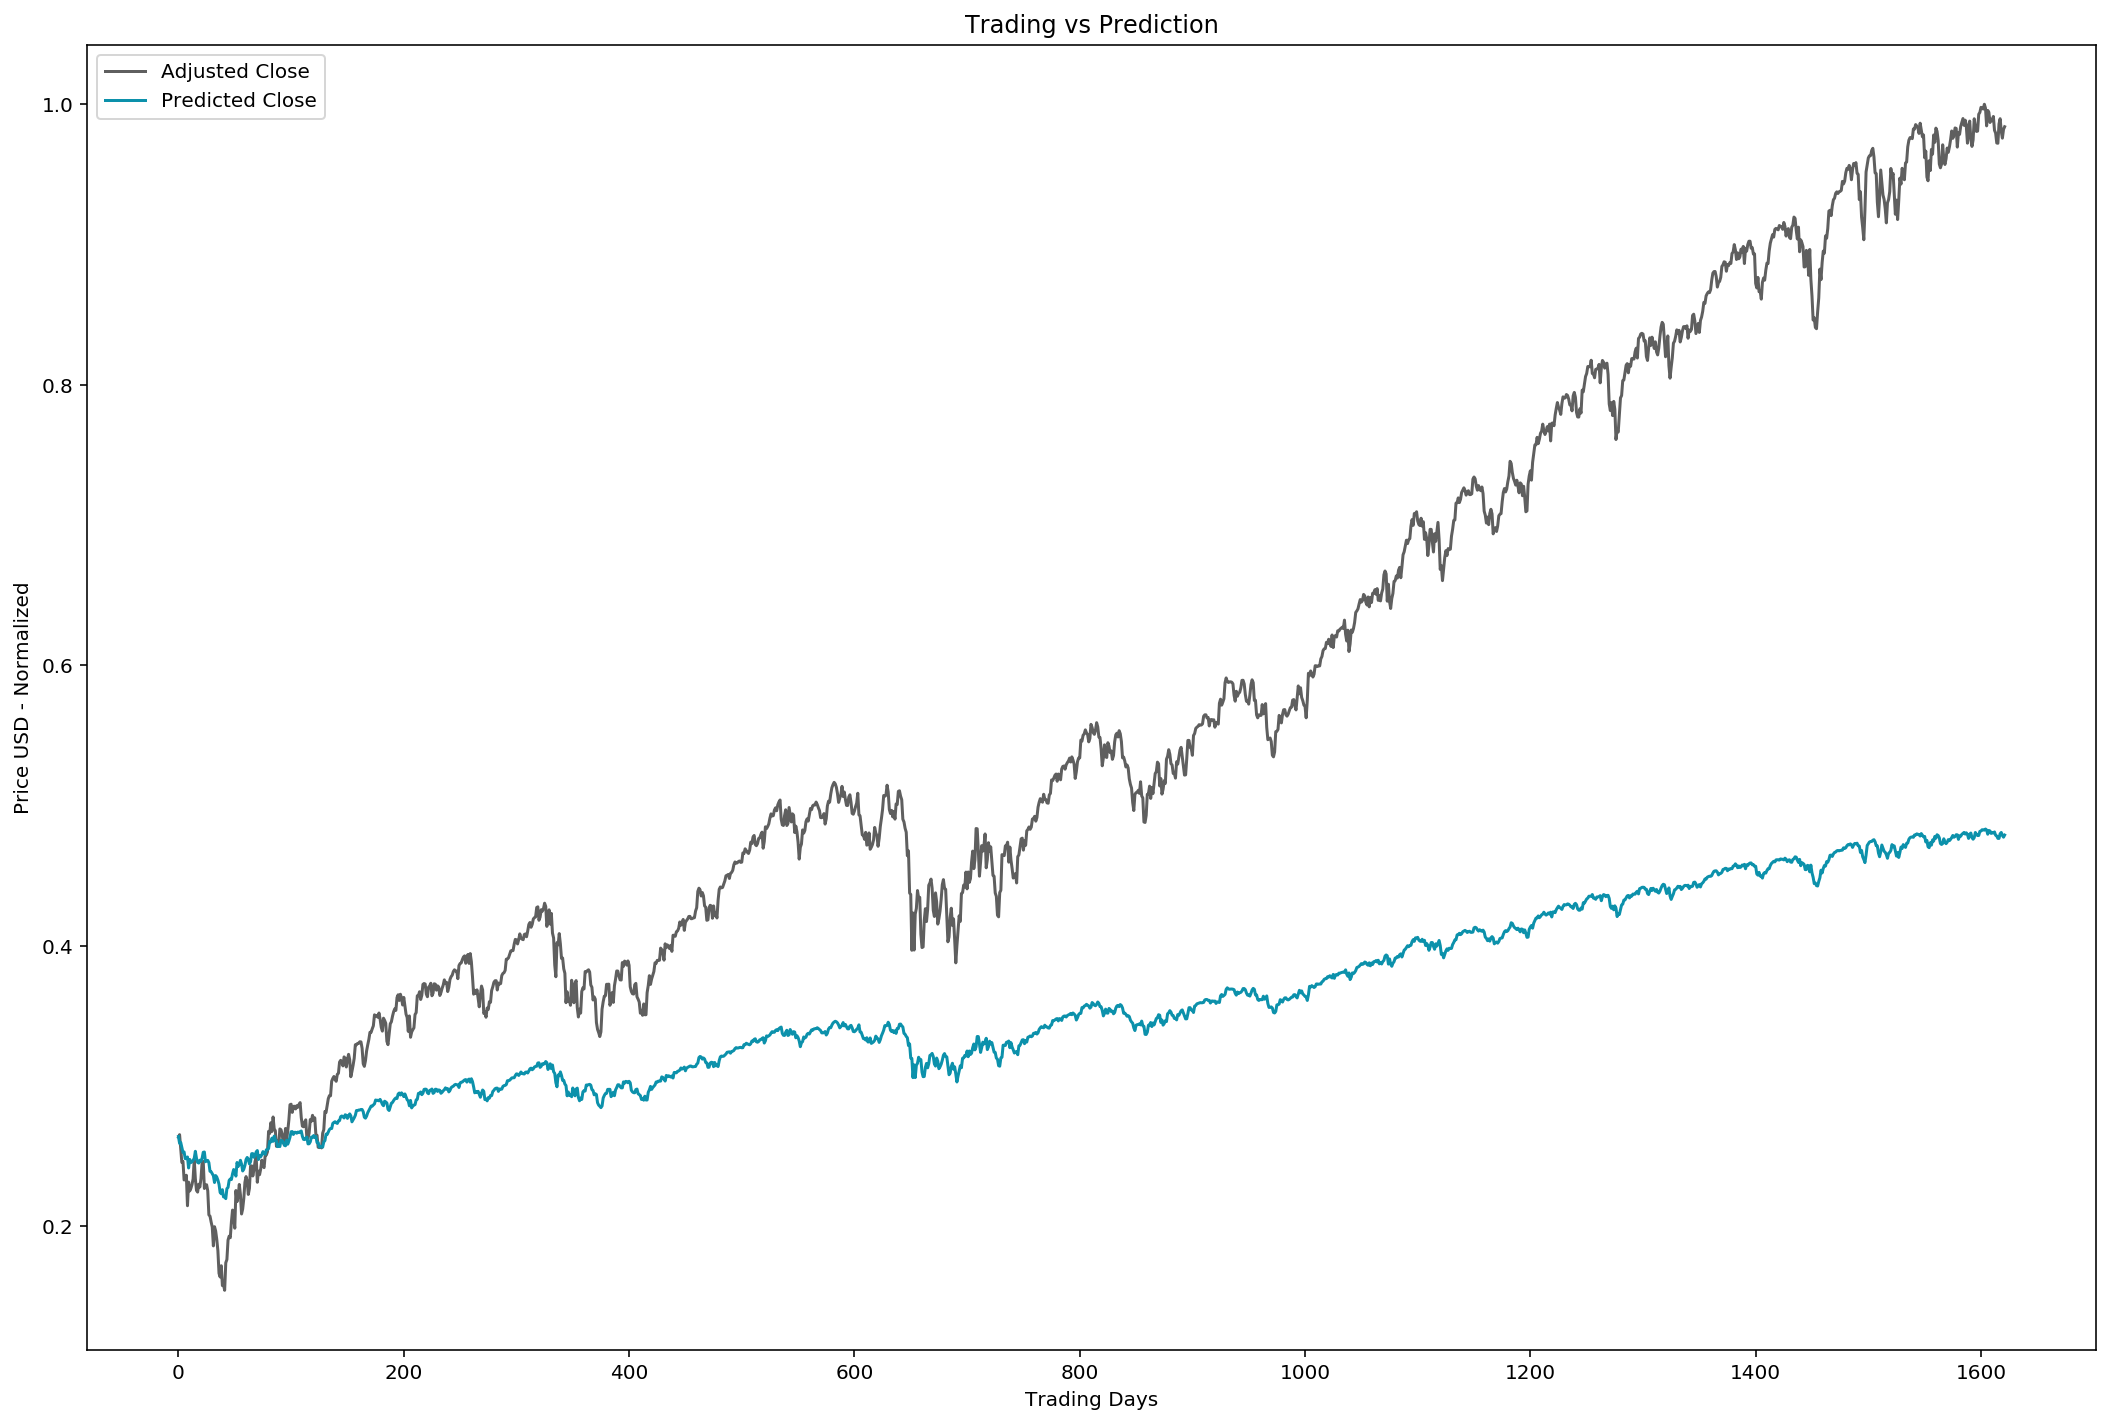

In [9]:
# Plot the predictions

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD - Normalized')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(y_close_test,'#5F5F5F', label='Adjusted Close')
plt.plot(testPredict, '#0C91AB', label='Predicted Close')

# Set title
ax.set_title('Trading vs Prediction')
ax.legend(loc='upper left')

plt.show()

In [10]:
# The mean squared error
testScore = model.evaluate(X_close_test, y_close_test, batch_size=batch_size, verbose=0)
print('Test Score: %.4f MSE (%.4f RMSE)' % (testScore, math.sqrt(testScore)))

Test Score: 0.0691 MSE (0.2629 RMSE)


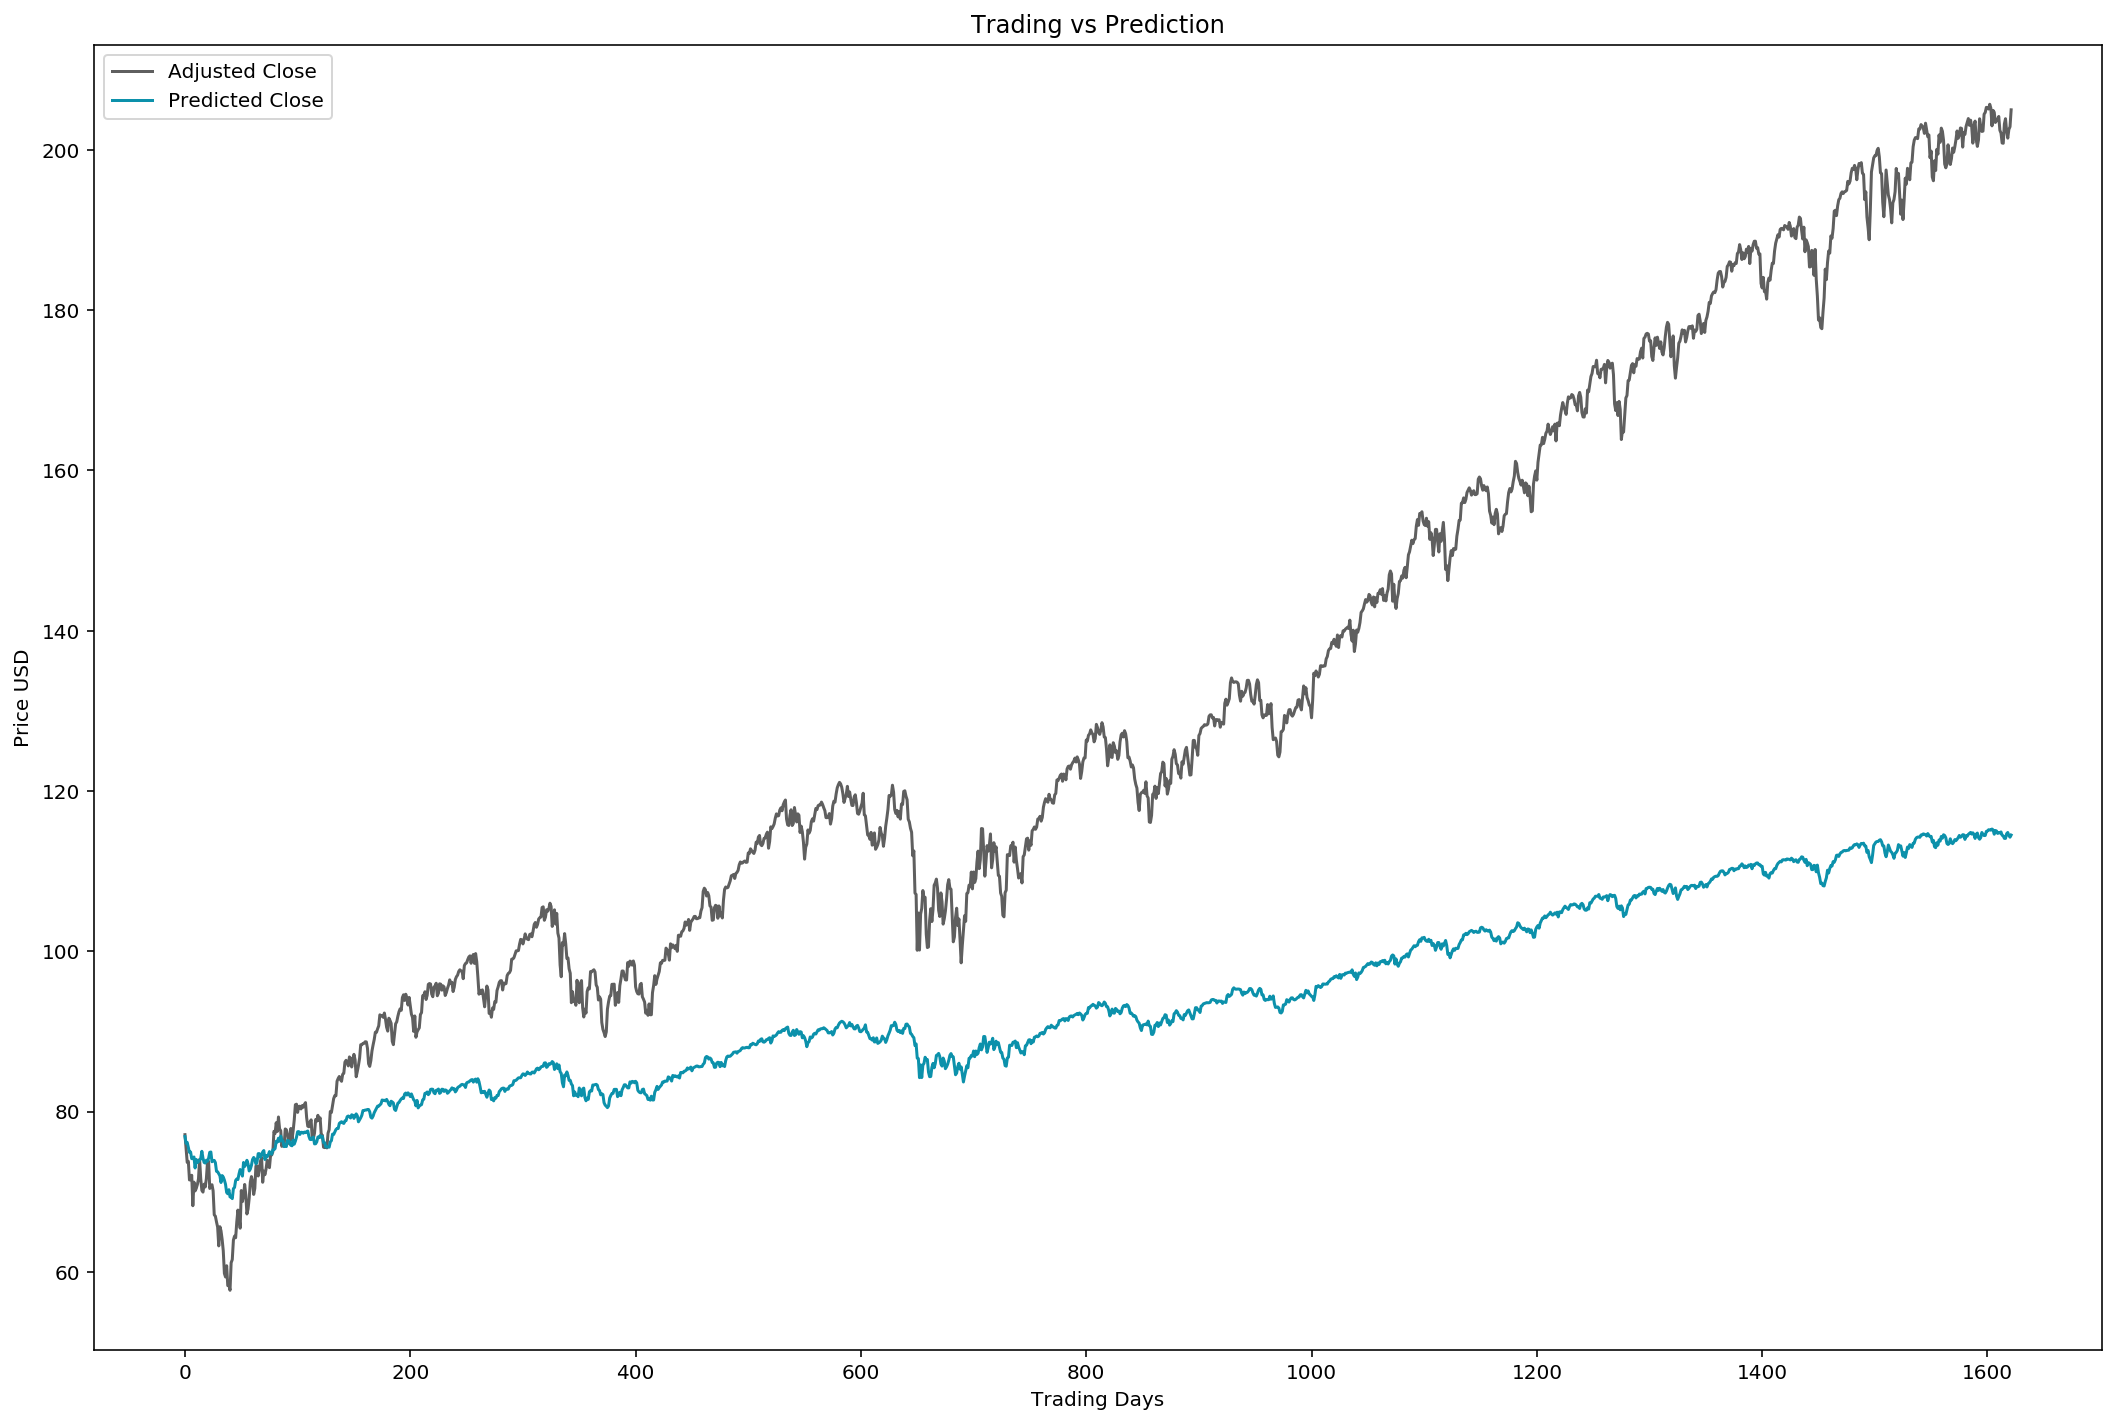

In [11]:
# Plot the predictions
close_plot = close_all[-y_close_test.shape[0]:]

pred_seq = np.array(testPredict)
#pprint(pred_seq)
preds_seq_plot, r = util.scale_range(pred_seq, input_range=[0.0,1.0], target_range=close_bounds)
#pprint(preds_seq_plot)

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')
# Plot actual and predicted close values

plt.plot(close_plot,'#5F5F5F', label='Adjusted Close')
plt.plot(preds_seq_plot, '#0C91AB', label='Predicted Close')

# Set title
ax.set_title('Trading vs Prediction')
ax.legend(loc='upper left')


# Log of Results:

### SPY

Epochs: 20 Lookback: 1 LSTM: 32 Test Score: 0.0401 MSE (0.2002 RMSE)

Epochs: 20 Lookback: 3 LSTM: 32 Test Score: 0.0673 MSE (0.2593 RMSE)

Epochs: 20 Lookback: 5 LSTM: 32 Test Score: 0.0583 MSE (0.2414 RMSE)

Epochs: 20 Lookback: 10 LSTM: 32 Test Score: 0.0831 MSE (0.2883 RMSE)


#### Archive

Lookback: 20 Test Score: 0.0028 MSE (0.0532 RMSE)

Lookback: 10 Test Score: 0.0011 MSE (0.0333 RMSE)

Lookback: 5 Test Score: 0.0009 MSE (0.0300 RMSE)

Lookback: 3 Test Score: 0.0006 MSE (0.0251 RMSE)

Lookback: 2 Test Score: 0.0008 MSE (0.0275 RMSE)

Lookback: 1 Test Score: 0.0001 MSE (0.0122 RMSE)


### GE
XX

### MSFT
XX

### AAPL
XX